# Discriminative DL Imputation Preparation

In [1]:
%cd ..

c:\Users\nick\OneDrive\Desktop\Prospect 33\Mini_DIVA


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd '/content/drive/My Drive/Mini_DIVA'

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

from imputers.discriminativeImputer import discriminativeDLImputer
from sklearn.metrics import mean_squared_error, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import losses, metrics

pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")
%matplotlib inline

## Loading data

In [4]:
# read the data
file_dir = "../Mini_DIVA/datasets/Automobile.csv"

df = pd.read_csv(file_dir)
df.head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,width,height,curb_weight,engine_type,num_of_cylinders,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.4,10.0,102,5500,24,30,13950
1,2,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.4,8.0,115,5500,18,22,17450
2,1,158,audi,gas,std,four,sedan,fwd,front,105.8,192.7,71.4,55.7,2844,ohc,five,136,mpfi,3.19,3.4,8.5,110,5500,19,25,17710
3,1,158,audi,gas,turbo,four,sedan,fwd,front,105.8,192.7,71.4,55.9,3086,ohc,five,131,mpfi,3.13,3.4,8.3,140,5500,17,20,23875
4,2,192,bmw,gas,std,two,sedan,rwd,front,101.2,176.8,64.8,54.3,2395,ohc,four,108,mpfi,3.50,2.8,8.8,101,5800,23,29,16430


In [5]:
# function for determining a categorical variable vs not (from utils.py)
def iscategorical(x, threshold=0.12):
    """
    determine if x is a categorical variable.


    Inputs:
    ------------------------------------------------------------
    x: pd.DataFrame or np.ndarray, a vector


    Outputs:
    ------------------------------------------------------------
    Bool value
    """
    # convert x to np.ndarray
    if isinstance(x, pd.DataFrame):
        x = x.to_numpy()

    if x.dtype in ["object", "bool", "str"]:
        return True
    elif len(np.unique(x[~np.isnan(x)])) < threshold * len(
        x[~np.isnan(x)]
    ):
        return True
    else:
        return False

In [6]:
# creating a mask for categorical variables the filtering the columns using it
categorical_mask = {col: iscategorical(df[col]) for col in df.columns}
cat_vars = [col for col, val in categorical_mask.items() if val == True]

# making a copy of the original dataframe to keep it unaltered
df_le = df.copy()

## Label Encoding and Setting Fraction of missing values and their indexes

Next we want to ensure that our data is fully numerical thus the label encoding. 

After that we will create missing values in the data then save their respective indexes for future use.

In [7]:
# label encode the data
for col in cat_vars:
    le = LabelEncoder()
    df_le[col] = le.fit_transform(df[col])

# saving the label encoded dataframe version
df_frac = df_le.copy()
random_state = 20

# set fraction missing in the dataframe
for idx, col in enumerate(df_frac.columns):
    missing = df_frac[col].sample(frac=0.08, random_state=random_state, replace=False).index.to_list()
    df_frac.iloc[missing, idx] = np.nan
    random_state += 2

In [8]:
# separating missing from complete data
missing_idx = {}
complete_idx = {}

for col in df_frac.columns:
    missing_idx[col] = list()
    key = missing_idx[col]
    for idx, rec in enumerate(df_frac[col]):
        if np.isnan(rec):
            key.append(idx)

## One-hot encoding

Before one hot encoding, we will have to fill in the missing values in the data with either the respective column's mode or mean. Because one hot encoding cannot be done on data that has nan values.

In [9]:
# # remove target Column
# cat_vars.remove('class')

In [10]:
# dictionary to save the values to be imputed per column
imputed_value = {}

# obtaining the mean/mode to use
for col in df_le.columns:
    
    if col in cat_vars:
        try:
            imputed_value[col] = float(df_le[col].mode())
        except TypeError:
            imputed_value[col] = float(df_le[col].mode()[0])

    else:
        imputed_value[col] = float(df_le[col].mean())

In [11]:
# instantiate the ohe encoder
ohe = OneHotEncoder(drop="first", sparse=False)
ohe.fit(df_le[cat_vars])

# one-hot encode the data
cat_transComp = ohe.transform(df_le[cat_vars])
cat_transNames = ohe.get_feature_names_out()

# switch them back to dataframes
cat_oheComp = pd.DataFrame(cat_transComp, columns=cat_transNames, index=df_le.index)
df_oheComp = cat_oheComp.join(df_le[[col for col in df_le.columns if col not in cat_vars]])
df_oheComp.sample(5)

,symboling_1,symboling_2,symboling_3,symboling_4,symboling_5,make_1,make_2,make_3,make_4,make_5,make_6,make_7,make_8,make_9,make_10,make_11,make_12,make_13,make_14,make_15,make_16,make_17,fuel_type_1,aspiration_1,num_of_doors_1,body_style_1,body_style_2,body_style_3,body_style_4,drive_wheels_1,drive_wheels_2,engine_type_1,engine_type_2,engine_type_3,engine_type_4,num_of_cylinders_1,num_of_cylinders_2,num_of_cylinders_3,num_of_cylinders_4,fuel_system_1,fuel_system_2,fuel_system_3,fuel_system_4,fuel_system_5,normalized_losses,wheel_base,length,width,height,curb_weight,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
35,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,104,93.1,159.1,64.2,54.1,1905,91,3.03,3.15,9.0,68,5000,31,38,6795
158,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,95,109.1,188.8,68.9,55.5,3062,141,3.78,3.15,9.5,114,5400,19,25,22625
86,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,154,93.7,157.3,63.8,50.6,1967,90,2.97,3.23,9.4,68,5500,31,38,6229
93,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,150,99.1,186.6,66.5,56.1,2707,121,2.54,2.07,9.3,110,5250,21,28,15040
142,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,94,97.3,171.7,65.5,55.7,2264,97,3.01,3.40,23.0,52,4800,37,46,7995


We have to revert the mean/mode imputed values back to Nan values for the next step of testing the discriminative DL imputer.

In [12]:
# converting previously imputed records back to null/nan
df_oheMiss = df_oheComp.copy()

for col in missing_idx:
    for missCol in df_oheMiss:
        if col in missCol:
            for idx, rec in enumerate(df_oheMiss[missCol]):
                if idx in missing_idx[col]:
                    df_oheMiss[missCol][idx] = np.nan

# Discriminative DL Imputation Implementation

In [13]:
# new cat vars since ohe was done on the data
num_vars_ = [col for col in df_le.columns if col not in cat_vars]
cat_vars_ = [col for col in df_oheComp.columns if col not in num_vars_]
# # adding the target variable back to the list
# cat_vars_.append("class")


Sequential deep learning models require different loss and 'final' activation functions for numerical vs categorical target data.

They are as follows:

- Categorical

    1. Binary Categories
        - Activation = sigmoid
        - Loss = binary crossentropy
    2. Multiple (>2) categories
        - Activation = softmax
        - Loss = categorical crossentropy

- Numerical
    - Activation = ReLu
    - Loss = MSE, RMSE, e.t.c


In [14]:
# oneRec = len(df_oheComp.iloc[0, :-1])
# oneCol = len(df_oheComp.iloc[:, 1])

# # instantiate the sequential model
# model = Sequential()

# # add the neccessary input, hidden, dropout and output layers
# model.add(Input(shape=(oneRec, )))
# model.add(Dense(56, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(24, activation='relu'))
# model.add(Dropout(0.05))
# model.add(Dense(4, activation='relu'))
# # model.add(Dense(len(np.unique(df_oheComp.iloc[:, -1])), activation="softmax"))
# model.add(Dense(1))

# model.compile(loss="mse", optimizer='adam', metrics=[metrics.MeanSquaredError()])
# model.fit(df_oheComp.iloc[:, 1:], df_oheComp.iloc[:, 0], epochs=150)
# predictions = model.predict(df_oheComp.iloc[:, 1:])

For testing how the imputer works and tuning it, we will only fit the imputer since at both training and testing phase of the imputer, the missing values in the data input are imputed with the underlying model.

In [15]:
# instantiating the imputer
dl = discriminativeDLImputer(num_vars_, cat_vars_)

# fitting the imputer
fitted_df = dl.fit(df_oheMiss)


1/1 [==============================] - 0s 153ms/step


In [16]:
print(f"Train data fed to the imputer had an average of {df_oheMiss.isna().sum().mean()} missing values per column.\n")
print(f"The resulting data after imputation has an average of {fitted_df.isna().sum().mean()} missing values per column")

Train data fed to the imputer had an average of 13.0 missing values per column.

The resulting data after imputation has an average of 0.0 missing values per column


## Investigating model performance

We will be using accuracy score for categorical variables and RMSE for numerical variables.

In [28]:
# variable to store the scores
score_dict = {}

# calculate the error scores for the imputation
for col, idxList in missing_idx.items():
    original = df_oheComp.iloc[idxList][[_ for _ in df_oheComp.columns if col in _]]
    predicted = fitted_df.iloc[idxList][[_ for _ in df_oheComp.columns if col in _]]
    
    if col in num_vars_:
        score = np.sqrt(mean_squared_error(original, predicted))
        score_dict[col] = score
    else:
        for var in original.columns:
            score = accuracy_score(original[var], predicted[var])
            score_dict[var] = score

# create a score dataframe
scores = pd.DataFrame.from_dict(score_dict, orient="index", columns=['Score']).reset_index()
scores.columns = ["Column", "Score"]

# # export the scores to a csv file for future reference
# scores.to_csv("../MINI_DIVA/ModelIterations/DLBaselineIter.csv")

In [46]:
# check the scores of the original DL model
first_results = pd.read_csv("../MINI_DIVA/ModelIterations/DLFirstIterRes.csv", names=['Column', 'Score'], skiprows=1)
first_results.sample(5, random_state=4)

,Column,Score
4,symboling_5,0.076923
20,make_15,0.307692
56,city_mpg,72.757809
24,aspiration_1,1.000000
12,make_7,0.076923


There is higher error in the imputation of numerical variables as compared to categorical variables. It is highly likely that the model architechture for the numerical variables is lacking. 

Next we will improve on the performance of DL imputer on numerical variables by reviewing the model architechture.

## Improved model architechture

To improve model perfomance on numerical target data, we added a hidden layer to the model architechture. 

The improvement in RMSE can be seen in the graph below. Since the main focus of the change is perfomance on numerical data which have high value metrics we will limit the y scale to:

        1 < y 

In [ ]:
# Improved model results
scores.sample(5, random_state=4)

,Column,Score
4,symboling_5,0.076923
20,make_15,0.692308
56,city_mpg,28.172590
24,aspiration_1,1.000000
12,make_7,0.923077


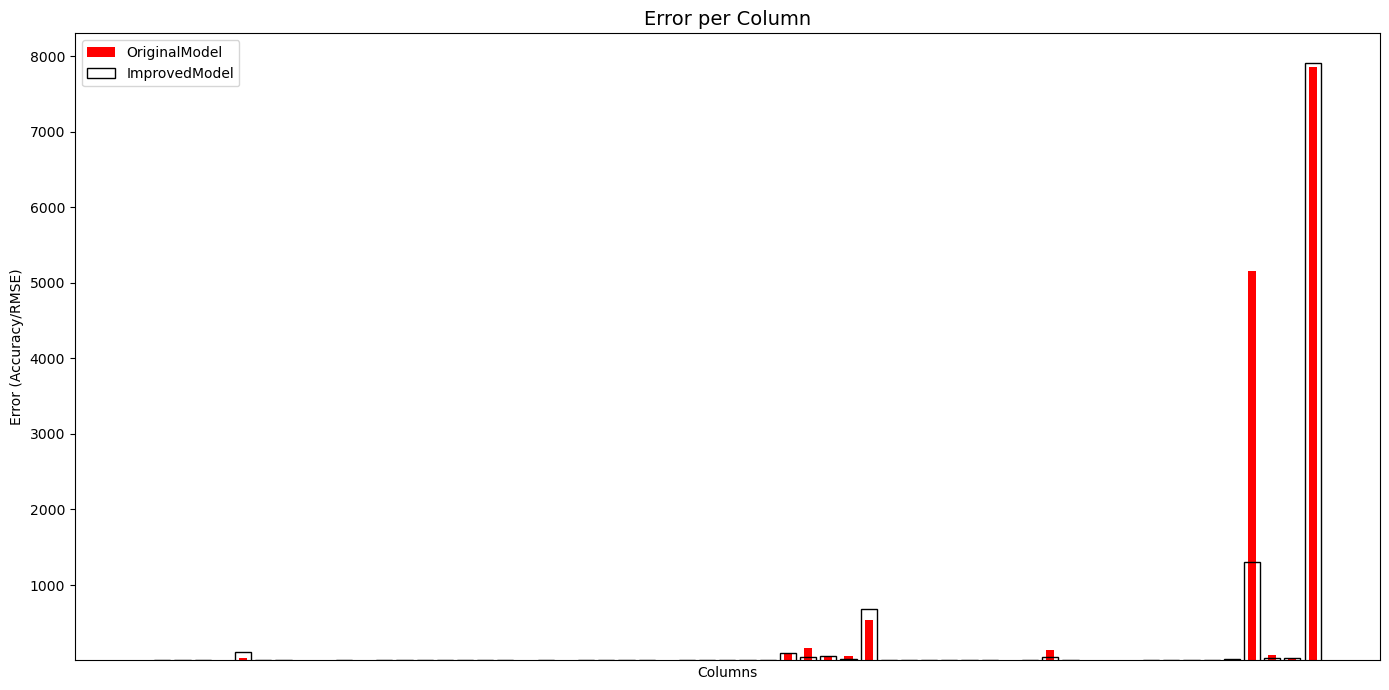

In [88]:
# line plot showing the different perfomance
plt.figure(figsize=(14, 7))
plt.bar(height=first_results["Score"], x=first_results["Column"], width=0.4, color="r", label="OriginalModel")
plt.bar(height=scores["Score"], x=scores["Column"], color="blue", fill=False, label="ImprovedModel")
plt.ylim(1)
plt.xticks(ticks=[])

plt.title("Error per Column", fontsize=14)
plt.xlabel("Columns")
plt.ylabel("Error (Accuracy/RMSE)")
plt.legend()
plt.tight_layout()
plt.show()

The imputation performance has improved overally after tweaking the model architechture.

## Removing outliers & Balancing categorical data
We can pause on adjusting the imputation methods  model architechture for now. The next phase is to try other methods to improve on the imputation perfomance.

First we will focus on getting rid of the extreme outliers in the data for continuous numerical data and balancing classes in the case of imbalanced categorical data. This should help in improving the 'predictions' of the models thereby improving on imputation.



In [47]:
scores

,Column,Score
0,symboling_1,0.076923
1,symboling_2,0.769231
2,symboling_3,0.538462
3,symboling_4,0.769231
4,symboling_5,0.076923
5,normalized_losses,109.590543
6,make_1,1.000000
7,make_2,1.000000
8,make_3,0.076923
9,make_4,0.153846
